In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer 
import re
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import string
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import joblib

In [25]:
warnings.filterwarnings('ignore')

In [26]:
df=pd.read_csv('train.csv',encoding='unicode_escape')
df.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet Age of User  \
0  I`d have responded, if I were going   neutral       morning        0-20   
1                             Sooo SAD  negative          noon       21-30   
2                          bullying me  negative         night       31-45   
3                       leave me alone  negative       morning       46-60   
4                        Sons of ****,  negative          noon       60-70   

       Country  Population -2020  Land Area (Km²)  Density (P/Km²)  
0  Afghanistan          38928346         652860.0               60  
1      Albania           2877797          27400.0              105  
2      Algeria          43851044        2381740.0               18  
3      Andorra             77265            470.0              164  
4       Angola          32866272        1246700.0               26

In [27]:
test_data = pd.read_csv('test.csv',encoding='unicode_escape')

In [29]:
test_data.head()

textID                                               text sentiment  \
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral   
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive   
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative   
3  01082688c6                                        happy bday!  positive   
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive   

  Time of Tweet Age of User      Country  Population -2020  Land Area (Km²)  \
0       morning        0-20  Afghanistan        38928346.0         652860.0   
1          noon       21-30      Albania         2877797.0          27400.0   
2         night       31-45      Algeria        43851044.0        2381740.0   
3       morning       46-60      Andorra           77265.0            470.0   
4          noon       60-70       Angola        32866272.0        1246700.0   

   Density (P/Km²)  
0             60.0  
1            105.0  
2             18.0  
3            164.0  
4             26.0

In [30]:
df.isna().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

since there are very less nan values so we can drop those rows which are nan

In [31]:
df.dropna(inplace=True)

In [32]:
test_data.dropna(inplace=True)

In [33]:
df['Age of User']

0          0-20
1         21-30
2         31-45
3         46-60
4         60-70
          ...  
27476     31-45
27477     46-60
27478     60-70
27479    70-100
27480      0-20
Name: Age of User, Length: 27480, dtype: object

In [34]:
df["sentiment"].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

There are 3 types of sentiments in the dataset

In [35]:
df["Age of User"].unique()

array(['0-20', '21-30', '31-45', '46-60', '60-70', '70-100'], dtype=object)

In [36]:
age_labels ={'0-20':0, '21-30':20, '31-45':31, '46-60':46, '60-70':60, '70-100':70}
df["Age of User"] = df["Age of User"].map(age_labels)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27480 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27480 non-null  object 
 4   Time of Tweet     27480 non-null  object 
 5   Age of User       27480 non-null  int64  
 6   Country           27480 non-null  object 
 7   Population -2020  27480 non-null  int64  
 8   Land Area (Km²)   27480 non-null  float64
 9   Density (P/Km²)   27480 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 2.3+ MB


In [38]:
# There is no significance of this column
df.drop(["textID"],axis=1,inplace=True)
test_data.drop(["textID"],axis=1,inplace=True)

In [39]:
df.head()

text  \
0                I`d have responded, if I were going   
1      Sooo SAD I will miss you here in San Diego!!!   
2                          my boss is bullying me...   
3                     what interview! leave me alone   
4   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet  Age of User  \
0  I`d have responded, if I were going   neutral       morning            0   
1                             Sooo SAD  negative          noon           20   
2                          bullying me  negative         night           31   
3                       leave me alone  negative       morning           46   
4                        Sons of ****,  negative          noon           60   

       Country  Population -2020  Land Area (Km²)  Density (P/Km²)  
0  Afghanistan          38928346         652860.0               60  
1      Albania           2877797          27400.0              105  
2      Algeria          43851044        2381740.0               18  
3      Andorra             77265            470.0              164  
4       Angola          32866272        1246700.0               26

<Axes: xlabel='sentiment', ylabel='count'>

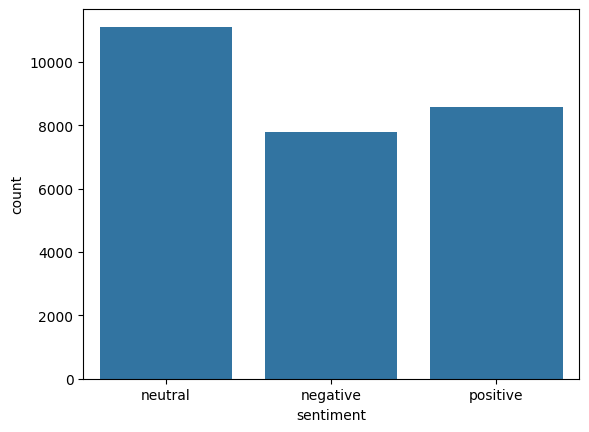

In [40]:
sns.countplot(x=df['sentiment'])

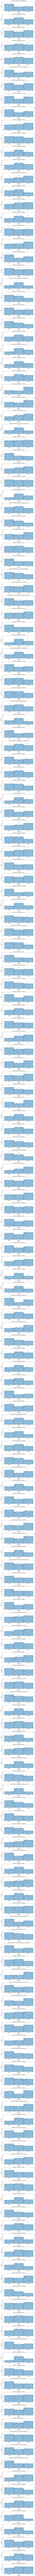

In [73]:
# Grouping the DataFrame by 'Country'
grouped = df.groupby('Country')

# Create a figure with subplots
fig, axs = plt.subplots(len(grouped), 1, figsize=(8, 3*len(grouped)))

# Iterate over each group
for i, (country, data) in enumerate(grouped):
    # Plot histogram for sentiment distribution for the current country
    sns.histplot(data['sentiment'], ax=axs[i], kde=True)
    axs[i].set_title(f'Sentiment Distribution for {country}')
    axs[i].set_xlabel('Sentiment')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

No dependendecy on Country . Almost all are distributed uniformly

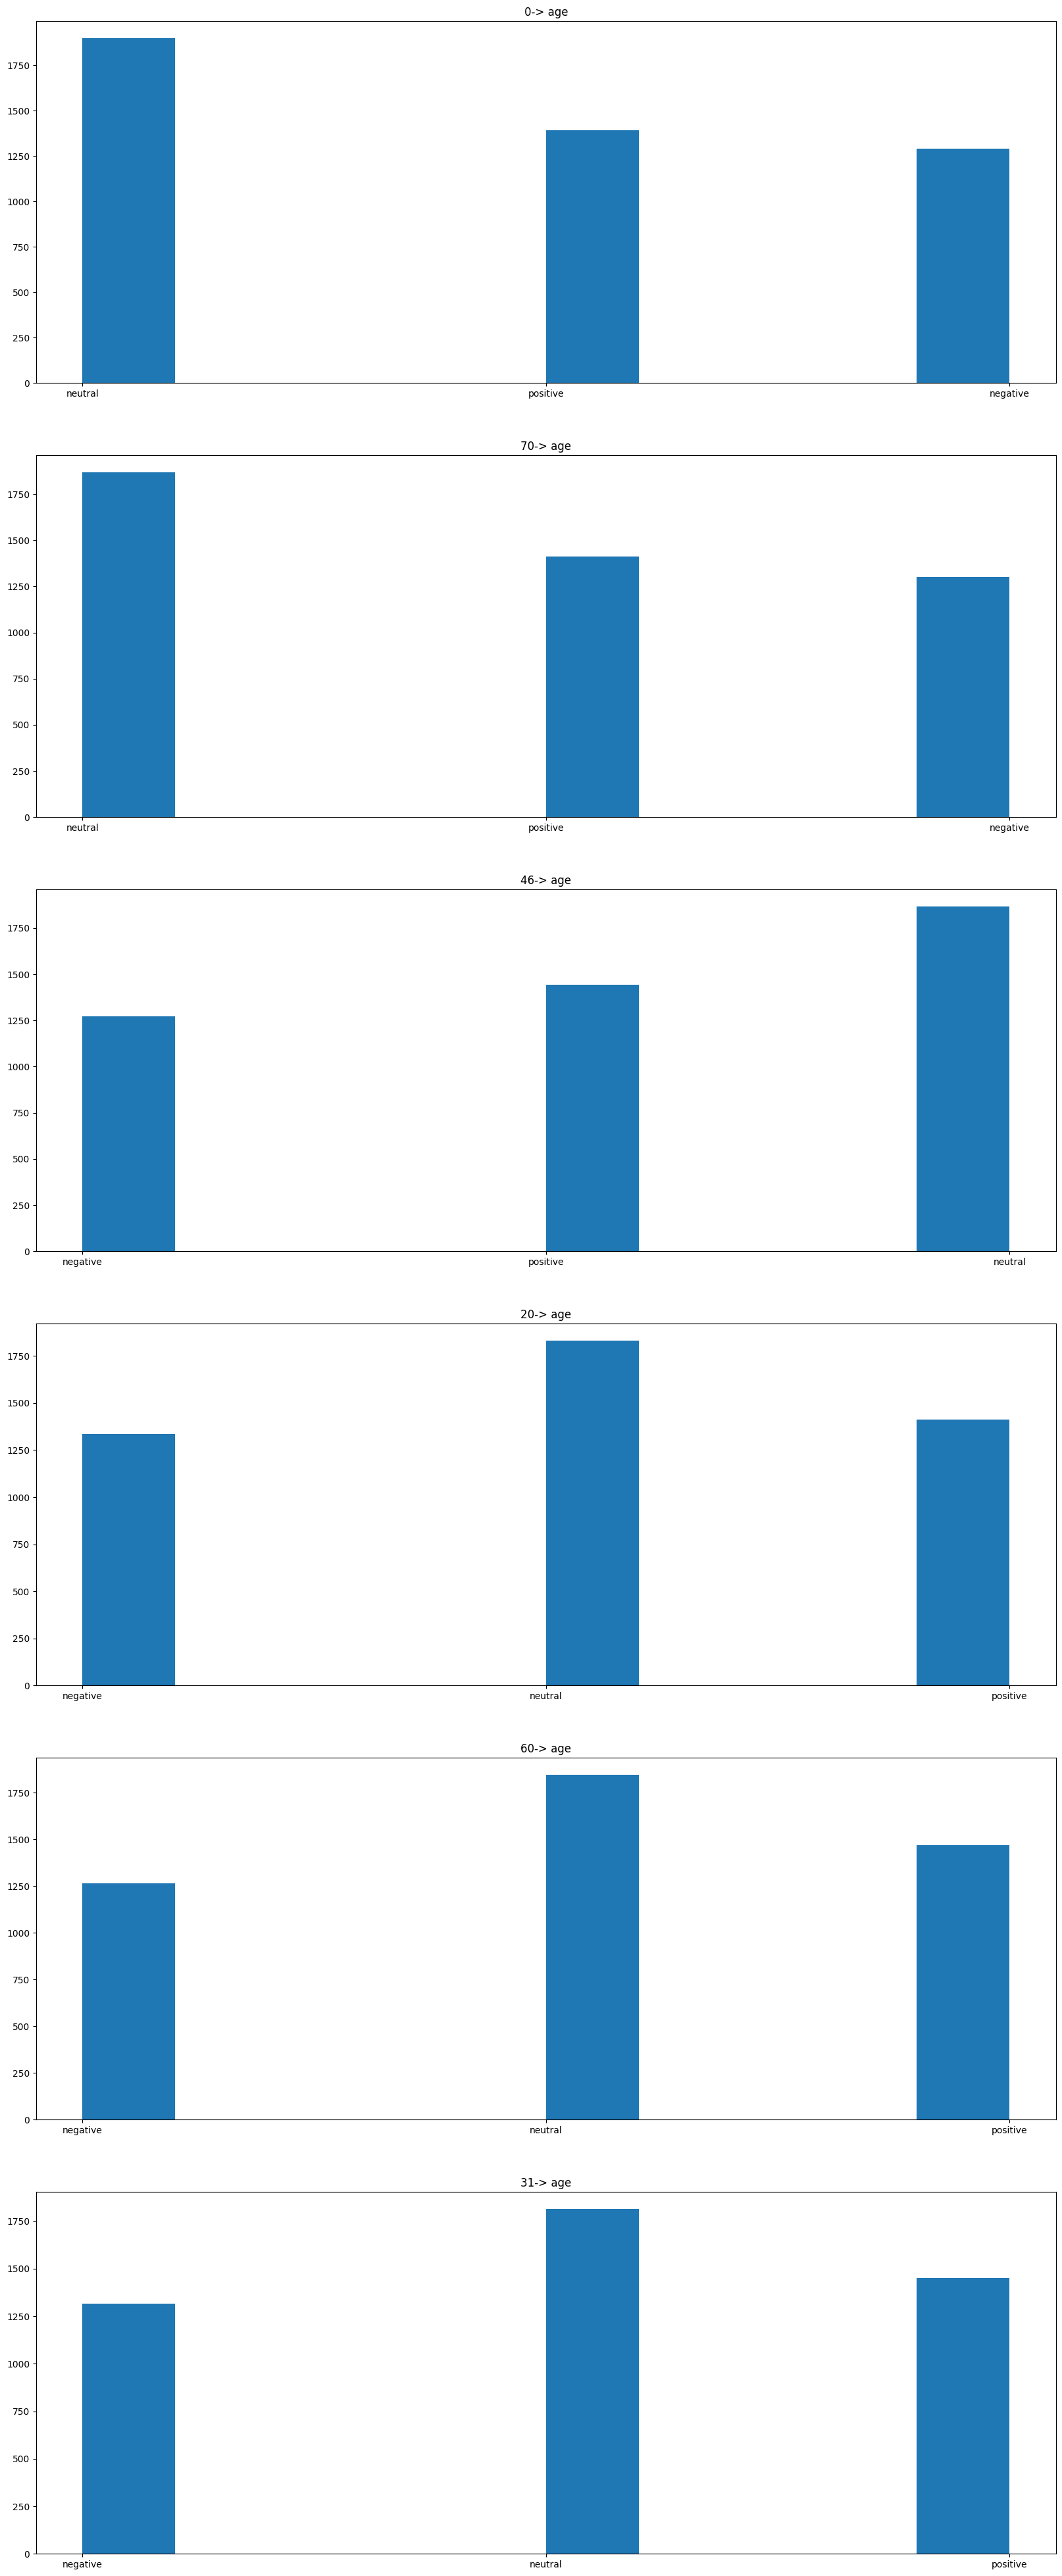

In [20]:
# Extracting unique age values from the 'Age of User' column
age = set(df['Age of User'])  
age = list(age)  # Converting the set of unique age values to a list
temp_df = [0] * len(age)  # Initializing a list to store separate DataFrames for each age group

# Looping through each unique age value and creating a DataFrame containing data for that age group
for i, ages in enumerate(age):
    temp_df[i] = df[df['Age of User'] == ages]

# Creating subplots to display histograms of sentiment distribution for each age group
fig = plt.figure(figsize=(20, 50))
ax2 = fig.subplots(6, 1)  # Creating 6 subplots vertically

# Plotting histograms for sentiment distribution for each age group
for i in range(6):
    ax2[i].hist(temp_df[i]['sentiment'])  # Plotting histogram for sentiment distribution
    ax2[i].set_title(str(age[i]) + '-> age')  # Setting title for each subplot with the corresponding age group


evenly distribution of sentiment inn age but it is slighly titled toward neutral 

In [41]:
# Dropping the 'Country' column from the DataFrame
df.drop(labels=['Country'], inplace=True, axis=1)  

# Dropping the 'Age of User' column from the DataFrame
df.drop(labels=['Age of User'], axis=1, inplace=True)  

# Dropping the 'Country' column from the test data
test_data.drop(labels=['Country'], inplace=True, axis=1)  

# Dropping the 'Age of User' column from the test data
test_data.drop(labels=['Age of User'], axis=1, inplace=True)

In [22]:
df.duplicated().any()

False

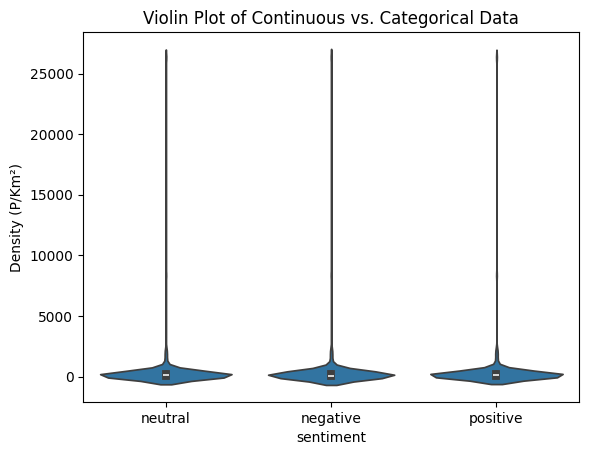

In [42]:
# Creating a violin plot to visualize the distribution of 'Density (P/Km²)' across different sentiment categories
sns.violinplot(x='sentiment', y='Density (P/Km²)', data=df)

# Adding labels to the x-axis and y-axis
plt.xlabel('sentiment')
plt.ylabel('Density (P/Km²)')

# Adding a title to the plot
plt.title('Violin Plot of Continuous vs. Categorical Data')

# Displaying the plot
plt.show()


As we can see that the median represented vy white dot is same for all the sentiment accross distribution so the Density does not  add any new information.

In [43]:
# Dropping the 'Density (P/Km²)' column from the DataFrame
df.drop(['Density (P/Km²)'], inplace=True, axis=1)

# Dropping the 'Density (P/Km²)' column from the test data
test_data.drop(['Density (P/Km²)'], inplace=True, axis=1)

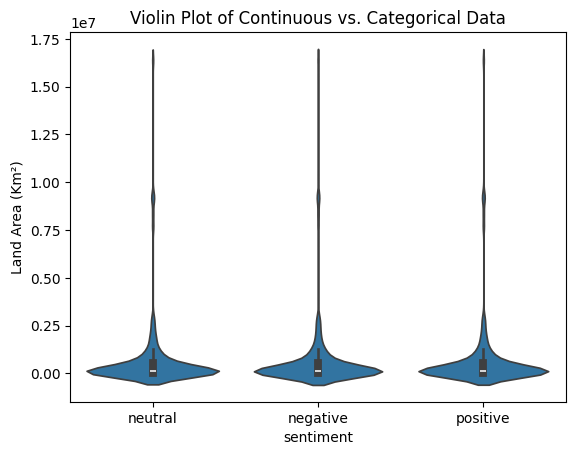

In [44]:
# Creating a violin plot to visualize the distribution of 'Land Area (Km²)' across different sentiment categories
sns.violinplot(x='sentiment', y='Land Area (Km²)', data=df)

# Adding labels to the x-axis and y-axis
plt.xlabel('sentiment')
plt.ylabel('Land Area (Km²)')

# Adding a title to the plot
plt.title('Violin Plot of Continuous vs. Categorical Data')

# Displaying the plot
plt.show()

In [45]:
# Dropping the 'Land Area (Km²)' column from the DataFrame
df.drop(['Land Area (Km²)'], inplace=True, axis=1)

# Dropping the 'Land Area (Km²)' column from the test data
test_data.drop(['Land Area (Km²)'], inplace=True, axis=1)


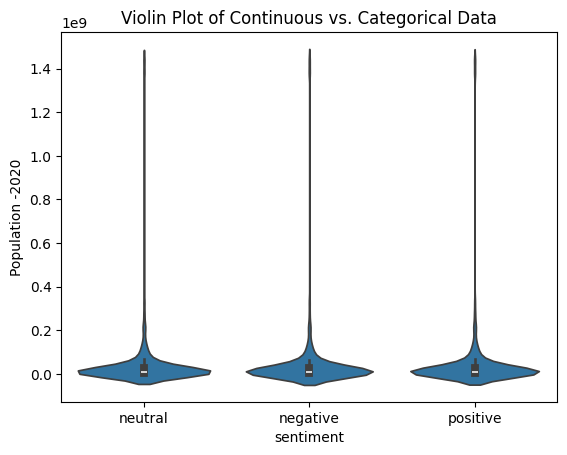

In [46]:
# Creating a violin plot to visualize the distribution of 'Population -2020' across different sentiment categories
sns.violinplot(x='sentiment', y='Population -2020', data=df)

# Adding labels to the x-axis and y-axis
plt.xlabel('sentiment')
plt.ylabel('Population -2020')

# Adding a title to the plot
plt.title('Violin Plot of Continuous vs. Categorical Data')

# Displaying the plot
plt.show()

In [47]:
# Dropping the 'Population -2020' column from the DataFrame
df.drop(['Population -2020'], axis=1, inplace=True)

# Dropping the 'Population -2020' column from the test data
test_data.drop(['Population -2020'], inplace=True, axis=1)


In [48]:
df.head()

text  \
0                I`d have responded, if I were going   
1      Sooo SAD I will miss you here in San Diego!!!   
2                          my boss is bullying me...   
3                     what interview! leave me alone   
4   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet  
0  I`d have responded, if I were going   neutral       morning  
1                             Sooo SAD  negative          noon  
2                          bullying me  negative         night  
3                       leave me alone  negative       morning  
4                        Sons of ****,  negative          noon

In [23]:
test_data.head()

text sentiment Time of Tweet
0  Last session of the day  http://twitpic.com/67ezh   neutral       morning
1   Shanghai is also really exciting (precisely -...  positive          noon
2  Recession hit Veronique Branquinho, she has to...  negative         night
3                                        happy bday!  positive       morning
4             http://twitpic.com/4w75p - I like it!!  positive          noon

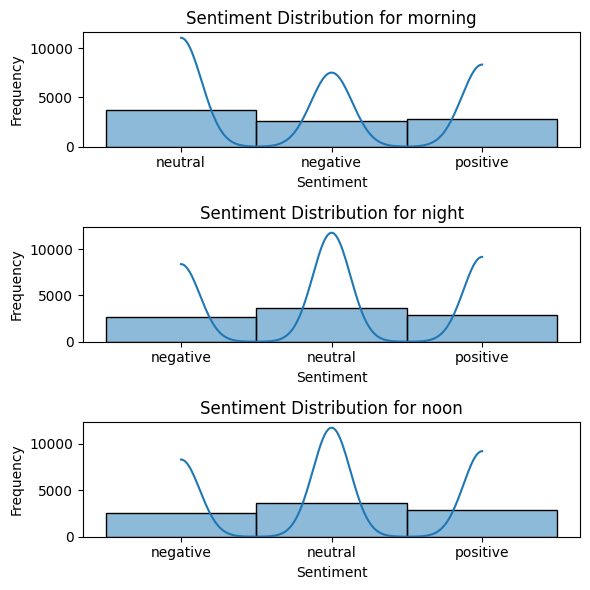

In [26]:
grouped = df.groupby('Time of Tweet')

# Create a figure with subplots
fig, axs = plt.subplots(len(grouped), 1, figsize=(6, 2*len(grouped)))

# Iterate over each group
for i, (country, data) in enumerate(grouped):
    # Plot histogram for sentiment distribution for the current country
    sns.histplot(data['sentiment'], ax=axs[i], kde=True)
    axs[i].set_title(f'Sentiment Distribution for {country}')
    axs[i].set_xlabel('Sentiment')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

We can see that there is not much time difference in the sentiment in the Time of Tweet.
So we can reject them as there is not much bisases toward any sentiment among all Tweets

In [49]:
# Dropping the 'Time of Tweet' column from the DataFrame
df.drop(["Time of Tweet"], axis=1, inplace=True)

# Dropping the 'Time of Tweet' column from the test data
test_data.drop(["Time of Tweet"], axis=1, inplace=True)


In [25]:
df.head()

text  \
0                I`d have responded, if I were going   
1      Sooo SAD I will miss you here in San Diego!!!   
2                          my boss is bullying me...   
3                     what interview! leave me alone   
4   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [26]:
test_data.head()

text sentiment
0  Last session of the day  http://twitpic.com/67ezh   neutral
1   Shanghai is also really exciting (precisely -...  positive
2  Recession hit Veronique Branquinho, she has to...  negative
3                                        happy bday!  positive
4             http://twitpic.com/4w75p - I like it!!  positive

In [50]:
# Creating DataFrame df_1 containing 'text' and 'sentiment' columns from df
df_1 = df[['text', 'sentiment']]

# Creating DataFrame df_2 containing 'selected_text' and 'sentiment' columns from df
df_2 = df[['selected_text', 'sentiment']]

# Creating DataFrame test2 containing 'text' and 'sentiment' columns from test_data
test2 = test_data[['text', 'sentiment']]


In [51]:
def textprocessing(text):
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove square brackets and their contents
    text = re.sub(r'\[.*?\]', '', text)
    
    # Replace non-word characters with a space
    text = re.sub(r'\W', ' ', text)
    
    # Remove XML tags
    text = re.sub(r'<.*?>+', '', text)
    
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    
    # Remove newline characters
    text = re.sub(r'\n', '', text)
    
    # Remove alphanumeric characters
    text = re.sub(r'\w*\d\w*', '', text)


    # Remove '@' and '#' symbols
    text = re.sub(r'\@\w+|\#', " ", text)

    
    # Tokenization
    text_tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english')) - {'not','no' , 'never'}
    text_no_stopwords = [word for word in text_tokens if word not in stop_words]
    
    # Lemmatization
    lem = SnowballStemmer('english')
    text_lemmatized = [lem.stem(word) for word in text_no_stopwords]
    text_processed = " ".join(text_lemmatized)
    
    return text_processed

In [52]:
# Applying textprocessing function to the 'text' column in DataFrame df_1
df_1['text'] = df_1['text'].apply(textprocessing)

# Applying textprocessing function to the 'text' column in DataFrame test2
test2['text'] = test2['text'].apply(textprocessing)

# Applying textprocessing function to the 'selected_text' column in DataFrame df_2
df_2["selected_text"] = df_2["selected_text"].apply(textprocessing)

In [53]:
test2.head()

text sentiment
0                                   last session day   neutral
1  shanghai also realli excit precis skyscrap gal...  positive
2  recess hit veroniqu branquinho quit compani shame  negative
3                                         happi bday  positive
4                                               like  positive

In [54]:
df_1.head()

text sentiment
0                     respond go   neutral
1        sooo sad miss san diego  negative
2                     boss bulli  negative
3            interview leav alon  negative
4  son put releas alreadi bought  negative

In [58]:
# Initializing the TF-IDF vectorizer
vector = tfidf()

# Fitting the vectorizer on the training data and transforming the 'text' column
x_train = vector.fit_transform(df_1['text'])

# Transforming the 'text' column in the test data using the same vectorizer
x_test = vector.transform(test2["text"])

# Checking the shape of the transformed training data
x_train.shape


(27480, 18657)

In [59]:
x_test.shape

(3534, 18657)

In [60]:
# Extracting the target labels from DataFrame df_1 and test2
y_train = df_1['sentiment']
y_test = test2["sentiment"]

# Initializing LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Printing the class labels and their encoded values
print("Class Labels:", label_encoder.classes_)
print("Encoded Values:", label_encoder.transform(label_encoder.classes_))

# Creating a dictionary to map encoded values to class labels
labels_map = {}
for i in range(len(label_encoder.classes_)):
    labels_map[label_encoder.transform(label_encoder.classes_)[i]] = label_encoder.classes_[i]

Class Labels: ['negative' 'neutral' 'positive']
Encoded Values: [0 1 2]


In [43]:
# Initializing the Support Vector Classifier with RBF kernel
svm = SVC(kernel='rbf')

# Fitting the SVM model on the training data
svm.fit(x_train, y_train)

# Predicting labels for the training data
y_pred_train = svm.predict(x_train)

# Predicting labels for the test data
y_pred = svm.predict(x_test)

# Calculating and printing the accuracy on train data
train_accuracy = accuracy_score(y_train, y_pred_train) * 100
print(f"The accuracy on train data for SVM model is {train_accuracy} %")

# Calculating and printing the accuracy on test data
test_accuracy = accuracy_score(y_test, y_pred) * 100
print(f"The accuracy on test data for SVM model is {test_accuracy} %")

The accuracy on train data for SVM model is 93.36608442503639 %
The accuracy on test data for SVM model is 72.46745897000567 %


In [54]:

# Define the model
model = Sequential()

model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],)))

# Add first hidden layer
model.add(Dense(64, activation='relu'))

# Add second hidden layer
model.add(Dense(128, activation='relu'))

# Output layer
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                597056    
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                                 
Total params: 607875 (2.32 MB)
Trainable params: 607875 (2.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
checkpoint_filepath = 'best_model_weights.h5'

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Add the checkpoint callback to the list of callbacks
callbacks_list = [checkpoint]

# Train the model with the callbacks
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/10
858/859 [============================>.] - ETA: 0s - loss: 0.7793 - accuracy: 0.6509
Epoch 1: val_accuracy improved from -inf to 0.71109, saving model to best_model_weights.h5
859/859 [==============================] - 9s 9ms/step - loss: 0.7790 - accuracy: 0.6510 - val_loss: 0.6728 - val_accuracy: 0.7111
Epoch 2/10
859/859 [==============================] - ETA: 0s - loss: 0.5129 - accuracy: 0.7975
Epoch 2: val_accuracy did not improve from 0.71109
859/859 [==============================] - 8s 10ms/step - loss: 0.5129 - accuracy: 0.7975 - val_loss: 0.7084 - val_accuracy: 0.6944
Epoch 3/10
856/859 [============================>.] - ETA: 0s - loss: 0.3481 - accuracy: 0.8713
Epoch 3: val_accuracy did not improve from 0.71109
859/859 [==============================] - 8s 9ms/step - loss: 0.3481 - accuracy: 0.8714 - val_loss: 0.8376 - val_accuracy: 0.6958
Epoch 4/10
859/859 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.9148
Epoch 4: val_accuracy did not

In [56]:
# Loading the weights of the model from the checkpoint file
model.load_weights(checkpoint_filepath)

# Initializing lists to store predicted labels and probabilities for test and train data
y_pred = []
y_pred_train = []

# Predicting probabilities for the test and train data
y_prob = model.predict(x_test)
y_prob_train = model.predict(x_train)

# Extracting predicted labels from predicted probabilities for test and train data
y_pred = np.argmax(y_prob, axis=1)
y_pred_train = np.argmax(y_prob_train, axis=1)

# Calculating and printing the accuracy on train data
train_accuracy = accuracy_score(y_train, y_pred_train) * 100
print(f"The accuracy on train data for ANN model is {train_accuracy} %")

# Calculating and printing the accuracy on test data
test_accuracy = accuracy_score(y_test, y_pred) * 100
print(f"The accuracy on test data for ANN model is {test_accuracy} %")


859/859 [==============================] - 1s 2ms/step
The accuracy on train data for ANN model is 82.62736535662299 %
The accuracy on test data for ANN model is 71.1092246745897 %


In [49]:
# Initializing the Multinomial Naive Bayes classifier with specified alpha
clf = MultinomialNB(alpha=0.5)

# Fitting the classifier on the training data
clf.fit(x_train, y_train)

# Predicting labels for the training data
y_pred_train = clf.predict(x_train)

# Predicting labels for the test data
y_pred = clf.predict(x_test)

# Calculating and printing the accuracy on train data
train_accuracy = accuracy_score(y_train, y_pred_train) * 100
print(f"The accuracy on train data for Naive Bayes model is {train_accuracy} %")

# Calculating and printing the accuracy on test data
test_accuracy = accuracy_score(y_test, y_pred) * 100
print(f"The accuracy on test data for Naive Bayes model is {test_accuracy} %")


The accuracy on train data for NaiveByes model is 80.62227074235808 %
The accuracy on test data for NaiveByes model is 63.24278438030561 %


In [50]:
# Initializing LogisticRegressionCV with specified regularization parameter and maximum iterations
lr = LogisticRegression(C=1.8, max_iter=200)

# Fitting the logistic regression model with cross-validation on the training data
lr.fit(x_train, y_train)

# Predicting labels for the training data
y_pred_train = lr.predict(x_train)

# Predicting labels for the test data
y_pred = lr.predict(x_test)

# Calculating and printing the accuracy on train data
train_accuracy = accuracy_score(y_train, y_pred_train) * 100
print(f"The accuracy on train data for Logistic Regression model is {train_accuracy:.2f} %")

# Calculating and printing the accuracy on test data
test_accuracy = accuracy_score(y_test, y_pred) * 100
print(f"The accuracy on test data for Logistic Regression model is {test_accuracy:.2f} %")


The accuracy on train data for LR model is 83.97016011644833 %
The accuracy on test data for LR model is 70.7696661007357 %


In [51]:
# Initializing the Random Forest classifier with 50 estimators and a random state
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

# Fitting the Random Forest model on the training data
rf_model.fit(x_train, y_train)

# Predicting labels for the training data
y_pred_train = rf_model.predict(x_train)

# Predicting labels for the test data
y_pred = rf_model.predict(x_test)

# Calculating and printing the accuracy on train data
train_accuracy = accuracy_score(y_train, y_pred_train) * 100
print(f"The accuracy on train data for Random Forest model is {train_accuracy:.2f} %")

# Calculating and printing the accuracy on test data
test_accuracy = accuracy_score(y_test, y_pred) * 100
print(f"The accuracy on test data for Random Forest model is {test_accuracy:.2f} %")


The accuracy on train data for RF model is 83.97016011644833 %
The accuracy on test data for RF model is 70.7696661007357 %


In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the logistic regression model
lr = LogisticRegression(max_iter=200)

# Define the hyperparameters and their values to be tuned
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga']}

# Initialize GridSearchCV
grid_search = GridSearchCV(lr, param_grid, cv=5)

# Perform grid search
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Use the best model for prediction
best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(x_test)

# Calculate accuracy
y_pred_train = best_lr.predict(x_train)
y_pred = best_lr.predict(x_test)
print(f"The accuracy on train data after hyperparameter tunning on LR model is {accuracy_score(y_train,y_pred_train)*100} %")
print(f"The accuracy on test data after hyperparameter tunning on LR model is {accuracy_score(y_test,y_pred)*100} %")


Best hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
The accuracy on train data after hyperparameter tunning on LR model is 74.66157205240175 %
The accuracy on test data after hyperparameter tunning on LR model is 71.90152801358234 %


In [53]:
# Saving the TF-IDF vectorizer
joblib.dump(vector, 'vector.pkl')

# Saving the SVM model
joblib.dump(svm, 'model.pkl')

['model.pkl']